## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import os
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_0_1_grid_0_02_features.npz"""
ROOT2 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_0_2_grid_0_04_features.npz"""
ROOT3 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_0_4_grid_0_08_features.npz"""
ROOT4 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_0_8_grid_0_16_features.npz"""
ROOT5 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_1_6_grid_0_32_features.npz"""
ROOT6 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/r_3_2_grid_0_64_features.npz"""

In [4]:
fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5, ROOT6]
# fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

# lastFi = np.load(fileList[-1], allow_pickle=True)["array2"]

# das = np.hstack((das, lastFi))

# xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

In [6]:
# del lastFi
gc.collect()

117

## Load in points and labels

## Combine road markings with Ground points

In [7]:
# cls[cls==2] = 1

In [8]:
# cls[cls > 1] -= 1

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [10]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [11]:
allCols = ff + ['label']

In [12]:
allAtrs = np.hstack((das, cls.reshape(-1, 1)))

In [13]:
del das, cls

## Create dataframe

In [14]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

    
# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [15]:
# del allAtrs

In [16]:
gc.collect()

0

In [17]:
# ss = ss[ss["count"] > 10]

In [18]:
# total_dataframe.head()

## Create PLY files with features (Only do if they don't already exist)

In [19]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [20]:
# total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
# total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [21]:
gc.collect()

0

In [22]:
# total_dataframe.head()

In [23]:
# total_dataframe.groupby("label").size() / total_dataframe.shape[0]

In [24]:
rf = RandomForestClassifier(verbose=1, n_jobs=8)

In [25]:
total_dataframe.reset_index(inplace = True)

In [26]:
gc.collect()

0

In [27]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        if SelectList.shape[0] == 0:
            continue
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState, replace = True)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.1s finished


Current accuracy: 92.1459


Current f1 score: 0.93015


Current f1 score delta: 0.93015
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.1s finished


Current accuracy: 93.1671


Current f1 score: 0.93828


Current f1 score delta: 0.00813
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.8s finished


Current accuracy: 93.7060


Current f1 score: 0.94270


Current f1 score delta: 0.00442
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.9s finished


Current accuracy: 94.0134


Current f1 score: 0.94522


Current f1 score delta: 0.00694
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.6s finished


Current accuracy: 94.4798


Current f1 score: 0.94931


Current f1 score delta: 0.00409
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.7s finished


Current accuracy: 94.7269


Current f1 score: 0.95139


Current f1 score delta: 0.00616
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.2s finished


Current accuracy: 94.9177


Current f1 score: 0.95306


Current f1 score delta: 0.00167
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.4s finished


Current accuracy: 95.1464


Current f1 score: 0.95506


Current f1 score delta: 0.00367
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.4s finished


Current accuracy: 95.3418


Current f1 score: 0.95684


Current f1 score delta: 0.00178
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.6s finished


Current accuracy: 95.4559


Current f1 score: 0.95782


Current f1 score delta: 0.00277
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   37.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.5s finished


Current accuracy: 95.6140


Current f1 score: 0.95923


Current f1 score delta: 0.00418
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.0s finished


Current accuracy: 95.6827


Current f1 score: 0.95978


Current f1 score delta: 0.00054
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.3s finished


Current accuracy: 95.7829


Current f1 score: 0.96068


Current f1 score delta: 0.00144
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   47.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.2s finished


Current accuracy: 95.8759


Current f1 score: 0.96149


Current f1 score delta: 0.00226
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   50.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.2s finished


Current accuracy: 95.9330


Current f1 score: 0.96202


Current f1 score delta: 0.00278
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   53.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.1s finished


Current accuracy: 96.0768


Current f1 score: 0.96326


Current f1 score delta: 0.00124
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   58.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.2s finished


Current accuracy: 96.1360


Current f1 score: 0.96380


Current f1 score delta: 0.00178
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.4s finished


Current accuracy: 96.1919


Current f1 score: 0.96424


Current f1 score delta: 0.00222
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.4s finished


Current accuracy: 96.2296


Current f1 score: 0.96466


Current f1 score delta: 0.00264
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.6s finished


Current accuracy: 96.3581


Current f1 score: 0.96579


Current f1 score delta: 0.00113
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished


Current accuracy: 96.4117


Current f1 score: 0.96632


Current f1 score delta: 0.00166
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.4s finished


Current accuracy: 96.4472


Current f1 score: 0.96664


Current f1 score delta: 0.00198
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished


Current accuracy: 96.5260


Current f1 score: 0.96733


Current f1 score delta: 0.00267
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.8s finished


Current accuracy: 96.5418


Current f1 score: 0.96751


Current f1 score delta: 0.00018
Starting iteration 25...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.4s finished


Current accuracy: 96.6135


Current f1 score: 0.96821


Current f1 score delta: 0.00087
Starting iteration 26...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.6s finished


Current accuracy: 96.6412


Current f1 score: 0.96844


Current f1 score delta: 0.00111
Starting iteration 27...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.3s finished


Current accuracy: 96.6765


Current f1 score: 0.96880


Current f1 score delta: 0.00147
Starting iteration 28...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.1s finished


Current accuracy: 96.7577


Current f1 score: 0.96958


Current f1 score delta: 0.00224
Starting iteration 29...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.8s finished


Current accuracy: 96.7705


Current f1 score: 0.96971


Current f1 score delta: 0.00014
Starting iteration 30...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   41.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.2s finished


Current accuracy: 96.7806


Current f1 score: 0.96982


Current f1 score delta: 0.00024
Starting iteration 31...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   43.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished


Current accuracy: 96.8382


Current f1 score: 0.97040


Current f1 score delta: 0.00083
Starting iteration 32...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.2s finished


Current accuracy: 96.9062


Current f1 score: 0.97102


Current f1 score delta: 0.00145
Starting iteration 33...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   46.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.3s finished


Current accuracy: 96.9333


Current f1 score: 0.97135


Current f1 score delta: 0.00177
Starting iteration 34...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   48.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.4s finished


Current accuracy: 96.9987


Current f1 score: 0.97193


Current f1 score delta: 0.00235
Starting iteration 35...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   50.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.3s finished


Current accuracy: 96.9975


Current f1 score: 0.97198


Current f1 score delta: 0.00005
DONE!!!!


In [28]:
gc.collect()

SelectList.shape

(2120957, 62)

## Plot iterations and accuracy

In [29]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

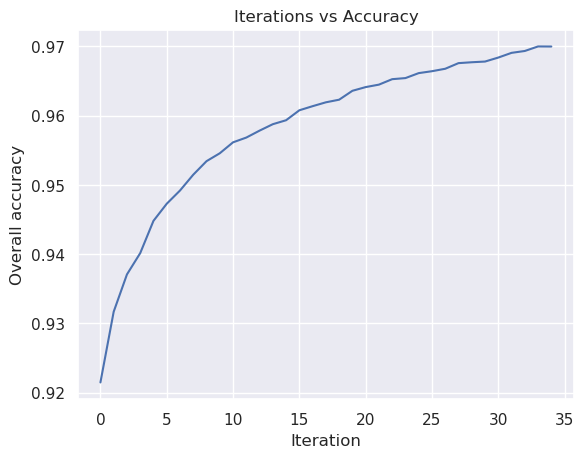

In [30]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [32]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_cylinder_RF_Lille.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_15_Trained_cylinder_RF_Lille.joblib']